In [1]:
#perform all imports for the lab
from zipfile import ZipFile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import numpy as np
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import os
import cv2
import shutil

#set use_cuda to true for GPU use
use_cuda = True

In [2]:
%pip install split-folders
import splitfolders

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#This ended up not being used
'''def folder_combiner(folder_path, destination_path):
  for emotion_folder in os.listdir(folder_path):
    emotion_folder_path = os.path.join(folder_path, emotion_folder)
    if os.path.isdir(emotion_folder_path):
        # Iterate through images in each emotion folder
        for filename in os.listdir(emotion_folder_path):
            if filename.endswith('.jpg') or filename.endswith('.png'):  # Add more extensions if needed
                src_path = os.path.join(emotion_folder_path, filename)
                dst_path = os.path.join(destination_path, f"{emotion_folder}_{filename}")  # Prefix with emotion label
                shutil.copy(src_path, dst_path)'''

In [4]:
train_folder_path = '/content/gdrive/My Drive/APS360 Project/kaggle_facial_emotion_data/train'
test_folder_path = '/content/gdrive/My Drive/APS360 Project/test'
test_destination_path = '/content/gdrive/My Drive/APS360 Project/Combined Data'
train_destination_path = ''

#folder_combiner(test_folder_path, test_destination_path)

In [ ]:
#Function to combine all of the class folders into a single folder
#Was supposed to do same thing as above function, also not used.
'''def load_images(folder_path):
    images = []
    labels = []
    emotion_folders = os.listdir(folder_path)
    for emotion_folder in emotion_folders:
        emotion_path = os.path.join(folder_path, emotion_folder)
        if os.path.isdir(emotion_path):
            label = emotion_folder  # Use folder name as the label
            for filename in os.listdir(emotion_path):
                img_path = os.path.join(emotion_path, filename)
                if img_path.endswith(".jpg") or img_path.endswith(".png"):  # Add more extensions if needed
                    img = cv2.imread(img_path)
                    if img is not None:
                        images.append(img)
                        labels.append(label)
    return images, labels'''

In [5]:
#should probably use the full dataset for consistency
#I'm just using the Kaggle test data set as the entire dataset b/c it'll be
#Enough data for this purpose. Split it into 80% train, 10% validation, 10% test
splitfolders.ratio('/content/gdrive/My Drive/APS360 Project/test', output="split_data",
    seed=999, ratio=(0.8, 0.1, 0.1), group_prefix=None, move=False)

Copying files: 7178 files [04:08, 28.94 files/s] 


In [6]:
transform = transforms.Compose(
        [transforms.ToTensor(),transforms.Resize((48,48))])

#transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224,224))])

#Create train, validation, and testing datasets
#Apply the transformations
train_data = ImageFolder("/content/split_data/train", transform)
val_data = ImageFolder("/content/split_data/val", transform)
test_data = ImageFolder("/content/split_data/test", transform)

#Load all of the datasets into their respective loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=10,
                                         shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=10,
                                          shuffle=True)

In [7]:
class CNN_EmotionClassifier(nn.Module):
    def __init__(self, name = "CNN_EmotionClassifier"):
        #Input image size = 3x48x48
        super(CNN_EmotionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5) #in_channels, out_chanels, kernel_size
        #output size = (48-5)/1 + 1 = 44
        #After pooling = 22
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
        #output size = (22-5)/1 + 1 = 18
        #after pooling = 9
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride
        self.fc1 = nn.Linear(10*9*9, 32)
        self.fc2 = nn.Linear(32, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10*9*9)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
#Get model name for checkpointing
def get_model_name(name, batch_size, learning_rate, epoch):
   path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size,
                                                  learning_rate, epoch)
   return path

In [9]:
#Find the accuracy of the model
def get_accuracy(model, data_loader):
    #initialize counters
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        #Enable GPU if available
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    #Return accuracy
    return correct / total

In [14]:
#plot accuracy
def plot_training_curve(path, num_epochs, train_acc, val_acc):
    plt.title("Training Curve")
    n = len(num_epochs) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [11]:
def train(model, train_loader, val_loader, batch_size=64, num_epochs=15,
          learn_rate=0.001, model_name='CNN_EmotionClassifier'):
    #Set seed
    torch.manual_seed(1700)

    #Set loss function and optimizer
    #I chose to use cross entropy loss for the loss function because
    #we have been taught that this is generally the best performing
    #loss function for multiclass classification problems.
    #I chose to use Adam as the optimizer because according to my
    #research, Adam generally provides very good results without
    #significant fine tuning.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)

    #populate accuracy arrays with zeroes
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)

    #initialize iteration counter
    n = 0
    for epoch in range(num_epochs):
        for images, labels in iter(train_loader):
            #Enable GPU if available
            if use_cuda and torch.cuda.is_available():
              images = images.cuda()
              labels = labels.cuda()

            #perform forwards pass
            out = model(images)
            #Compute loss using Cross Entropy loss function
            loss = criterion(out, labels)
            #backward pass to calculate and update parameters.
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            #increment iteration counter
            n += 1

        # track training and validation accuracy
        train_acc[epoch] = get_accuracy(model, train_loader)
        val_acc[epoch] = get_accuracy(model, val_loader)

        #output accuracy
        print(("Epoch: {} | Training acc: {} |" + "Validation acc: {}"
        ).format(epoch, train_acc[epoch], val_acc[epoch]))

        #checkpoint model
        model_path = get_model_name(model_name, batch_size, learn_rate,
                                    epoch)
        torch.save(model.state_dict(), model_path)

    epochs = np.arange(1, num_epochs + 1)

    #plot training curve
    plot_training_curve(model_path, epochs, train_acc, val_acc)

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0 | Training acc: 0.2 |Validation acc: 0.2
Epoch: 1 | Training acc: 0.5 |Validation acc: 0.5
Epoch: 2 | Training acc: 0.5 |Validation acc: 0.5
Epoch: 3 | Training acc: 0.5 |Validation acc: 0.5
Epoch: 4 | Training acc: 0.5 |Validation acc: 0.5
Epoch: 5 | Training acc: 0.5 |Validation acc: 0.5
Epoch: 6 | Training acc: 0.5 |Validation acc: 0.5
Epoch: 7 | Training acc: 0.5 |Validation acc: 0.5
Epoch: 8 | Training acc: 0.5 |Validation acc: 0.5
Epoch: 9 | Training acc: 0.5 |Validation acc: 0.5
Epoch: 10 | Training acc: 0.5 |Validation acc: 0.5
Epoch: 11 | Training acc: 0.5 |Validation acc: 0.5
Epoch: 12 | Training acc: 0.5 |Validation acc: 0.5
Epoch: 13 | Training acc: 0.5 |Validation acc: 0.5
Epoch: 14 | Training acc: 0.5 |Validation acc: 0.5
Epoch: 15 | Training acc: 0.5 |Validation acc: 0.5
Epoch: 16 | Training acc: 0.5 |Validation acc: 0.5
Epoch: 17 | Training acc: 0.5 |Validation acc: 0.5
Epoch: 18 | Training acc: 0.6 |Validation acc: 0.6
Epoch: 19 | Training acc: 0.6 |Validation

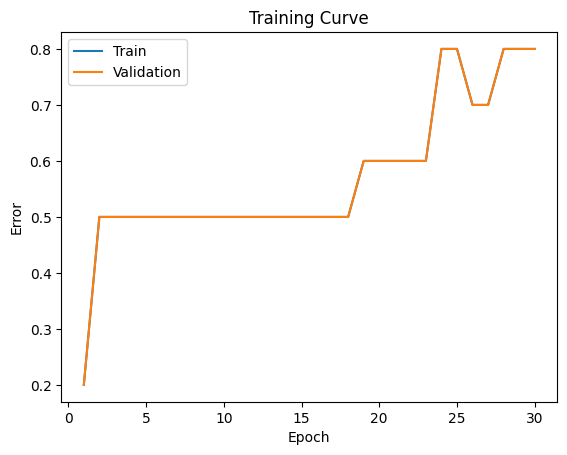

In [12]:
#Overfitting on small dataset for sanity check

model = CNN_EmotionClassifier()

#sample 10 random indices from the training data
indices = np.random.choice(len(train_data), size=10, replace=False)
#create an overfit dataset as a subset of the training dataset
overfit_data = Subset(train_data, indices)
#Load the overfit dataset
overfit_loader = DataLoader(overfit_data, batch_size=2, shuffle=True)

#Enable GPU if available.
if use_cuda and torch.cuda.is_available():
  model.cuda()

train(model, overfit_loader, overfit_loader, num_epochs=30, batch_size=27,
      learn_rate=0.001)
#Please note that since I passed the overfit_loader for both the
#parameters train_loader and val_loader, the training and validation
#accuracy seen here will be identical because they are the same thing

Epoch: 0 | Training acc: 0.24830109775222164 |Validation acc: 0.24895104895104894
Epoch: 1 | Training acc: 0.3214845791949817 |Validation acc: 0.3104895104895105
Epoch: 2 | Training acc: 0.3392577104025091 |Validation acc: 0.34405594405594403
Epoch: 3 | Training acc: 0.36086426206656214 |Validation acc: 0.35804195804195804
Epoch: 4 | Training acc: 0.3767206830458268 |Validation acc: 0.3622377622377622
Epoch: 5 | Training acc: 0.38212232096184007 |Validation acc: 0.35664335664335667
Epoch: 6 | Training acc: 0.389440669106116 |Validation acc: 0.37202797202797205
Epoch: 7 | Training acc: 0.4094790033106813 |Validation acc: 0.38181818181818183
Epoch: 8 | Training acc: 0.40634256839170585 |Validation acc: 0.37622377622377623
Epoch: 9 | Training acc: 0.41801707614566996 |Validation acc: 0.386013986013986
Epoch: 10 | Training acc: 0.4340477435093222 |Validation acc: 0.3958041958041958
Epoch: 11 | Training acc: 0.4453737584945112 |Validation acc: 0.4027972027972028
Epoch: 12 | Training acc: 0.

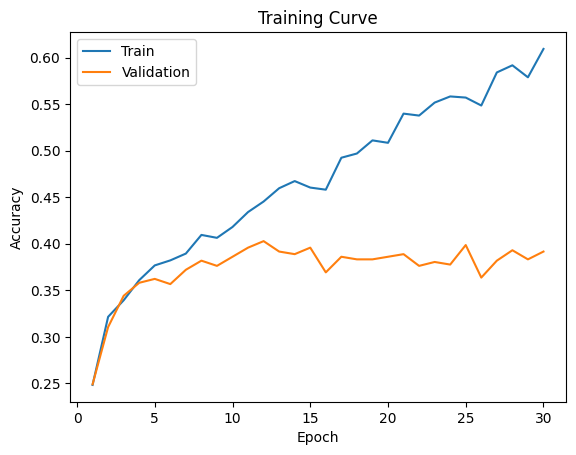

In [15]:
model1 = CNN_EmotionClassifier()
if use_cuda and torch.cuda.is_available():
  model1.cuda()

train(model1, train_loader, val_loader, num_epochs = 30)